In [15]:

class CircularVector:
    def __init__(self, size):
        self.size = size
        self.vector = [None] * size
        self.begin = 0  # Índice de início
        self.end = 0  # Índice de end
        self.currently_size = 0  # Tamnho atual do vector

    def add(self, element):
        if self.currently_size < self.size:
            self.vector[self.end] = element
            self.end = (self.end + 1) % self.size
            self.currently_size += 1

    def remove(self):
        if self.currently_size > 0:
            removed_element = self.vector[self.begin]
            self.begin = (self.begin + 1) % self.size
            self.currently_size -= 1
            return removed_element

    def __str__(self):
        return f"{self.vector}"

    def __len__(self):
        return len(self.vector)

    def get_ia_player_by_index(self, pos):
        return self.vector[pos % self.size]

    def set_new_vetor(self, vector):
        self.vector = vector

    def get_vector(self):
        vec = []
        for el in self.vector:
            vec.append(el.player.name)
        return vec

    def get_vector_of_numbers(self):
        vec = []
        for el in self.vector:
            list_vect = el.player.name.split()
            numb = int(list_vect[1])
            vec.append(numb)
        return vec

In [16]:
import random
from abc import ABC, abstractmethod
class Card:
    def __init__(self, rank, color) -> None:
        self.rank = rank
        self.color = color

    def __str__(self) -> str:
        return f"Card ({self.rank}, {self.color})"

    def execute_move(self, machine, players):
        pass

# abstract class that have only abstract methods -> INTERFACE in python
class Behavior(ABC):
    @abstractmethod
    def execute(machine, players: CircularVector):
        pass


class BlockNextPlayer(Behavior):
    def execute(machine, players):
        machine.INDEX_WHO_IS_PLAYING += 1


class Reverse(Behavior):
    def execute(machine, players):
        ##getting the last player's position on vector
        currently_player_name = (
            players.vector[machine.INDEX_WHO_IS_PLAYING % len(players)]
            .get_player()
            .name.split()
        )
        currently_player_number = int(currently_player_name[1])

        ##reversing vector
        players.vector.reverse()

        # updating vector by currently player index
        machine.INDEX_WHO_IS_PLAYING = players.get_vector_of_numbers().index(
            currently_player_number
        )


class DrawTwoCards(Behavior):
    def execute(machine, players):
        if len(machine.uno_deck.cards) < 2:
            machine.refuel_deck()

        new_cards = [machine.take_new_card_from_deck() for i in range(0, 2)]

        for card in new_cards:
            players.get_ia_player_by_index(
                machine.INDEX_WHO_IS_PLAYING + 1
            ).get_player().add_cart_to_list(card)


class DrawFourCards(Behavior):
    def execute(machine, players):
        if len(machine.uno_deck.cards) < 4:
            machine.refuel_deck()

        new_cards = [machine.take_new_card_from_deck() for i in range(0, 4)]

        for card in new_cards:
            players.get_ia_player_by_index(
                machine.INDEX_WHO_IS_PLAYING + 1
            ).get_player().add_cart_to_list(card)


class ChangeColor(Behavior):
    def execute(machine, players):
        new_color = random.sample(machine.uno_deck.colors, 1)
        machine.CURRENTLY_CARD.extra = new_color[0]
        # machine.CURRENTLY_CARD.color = new_color[0]


# class of ActionCard extends from Card
class ActionCard(Card):
    def __init__(self, rank, color, behavior: Behavior) -> None:
        super().__init__(rank, color)
        self.behavior = behavior

    def execute_move(self, machine, players):
        self.behavior.execute(machine, players)


from dataclasses import dataclass


@dataclass
class Player:
    _cards: list

    def __init__(self, name):
        self._name = name

    @property
    def name(self):
        return self._name

    def setcards(self, value):
        self._cards = value[:]

    @property
    def cards(self):
        return self._cards

    def delete_card_from_list(self, card):
        self.cards.remove(card)

    def add_cart_to_list(self, card):
        self.cards.append(card)

    def reset_player(self):
        self.cards.clear()


class UnoDeck:
    colors = "blue yellow red green".split()
    min_cards_on_deck = 4
    number_of_cards_for_each_player = 7
    deck_length = 108

    def __init__(self):
        self.cards = []
        self.discard_pile = []

        # adding common cards to deck
        for color in self.colors:
            self.cards.append(Card(0, color))
            for i in range(1, 10):
                self.cards.append(Card(i, color))
                self.cards.append(Card(i, color))

        # adding action and wild cards to deck
        for color in self.colors:
            self.cards.append(ActionCard("X", color, BlockNextPlayer))
            self.cards.append(ActionCard("X", color, BlockNextPlayer))
            self.cards.append(ActionCard("R", color, Reverse))
            self.cards.append(ActionCard("R", color, Reverse))
            self.cards.append(ActionCard("+", color, DrawTwoCards))
            self.cards.append(ActionCard("+", color, DrawTwoCards))
            self.cards.append(ActionCard("W", color, DrawFourCards))
            self.cards.append(WildCard("C", color, ChangeColor))

        self.CARDS_DEFAULT_DECK = self.cards.copy()

    def get_cards_length(self):
        return len(self.cards)

    def can_this_number_of_players_play_uno(self, number_of_players):
        if (
            (self.deck_length - self.min_cards_on_deck)
            / self.number_of_cards_for_each_player
        ) < number_of_players:
            return False
        elif number_of_players < 1:
            return False
        else:
            return True

    def need_to_refuel_deck(self):
        return len(self.cards) == 0

    def draw_a_card_from_deck(self):
        new_card = random.sample(self.cards, 1)
        self.delete_cards_from_deck(new_card)
        return new_card[0]

    def delete_cards_from_deck(self, cards_to_delete):
        if isinstance(cards_to_delete, Card):
            self.cards.remove(cards_to_delete)

        elif isinstance(cards_to_delete, list):
            for card in cards_to_delete:
                self.cards.remove(card)

    def refuel_deck(self):
        # getting all remaining cards together
        self.cards = self.cards + self.discard_pile
        # get the last one who was thrown
        first_element_of_new_pile = self.cards.pop(0)
        # clear discard pile and append the last card thrown
        self.discard_pile.clear()
        self.discard_pile.append(first_element_of_new_pile)

    def shuffle_cards(self):
        random.shuffle(self.cards)

    def discard_a_card(self, card):
        self.discard_pile.append(card)

    def get_a_uno_hand(self):
        hand = random.sample(self.cards, self.number_of_cards_for_each_player)
        self.delete_cards_from_deck(hand)
        return hand

    def reset(self, players_input_fixed: list[list[Card]]):
        self.cards = self.CARDS_DEFAULT_DECK.copy()
        self.discard_pile = []
        # deleting initial hands for another simulation
        for player_input in players_input_fixed:
            self.delete_cards_from_deck(player_input)

In [17]:
class WildCard(Card):
    def __init__(self, rank, color, behavior: Behavior) -> None:
        super().__init__(rank, color)
        self.behavior = behavior
        self.user_choice = None

    def execute_move(self, machine, players):
        self.behavior.execute(machine, players)


class IA_Player:
    def __init__(self, name):
        self.player = Player(name)

    def insert_uno_machine(self, machine):
        self.UNO_MACHINE = machine

    def receive_first_hand(self, cards):
        self.player.my_cards = cards

    def get_player(self):
        return self.player

    def get_player_name(self):
        return self.player.name

    def get_player_cards(self):
        return self.player.cards

    def throw_card_away(self, card):
        self.player.delete_card_from_list(card)  # deleting in player's hand
        self.UNO_MACHINE.discard_a_card(card)  # adding to the discard pile

    def draw_from_deck(self, card):
        self.player.add_cart_to_list(card)

    def move(self) -> Card:  # the player's move
        list_of_possible_throws = self.possible_player_card_throws()
        return_card = None

        if len(list_of_possible_throws) == 0:  # user takes another card
            new_card = self.UNO_MACHINE.take_new_card_from_deck()
            self.draw_from_deck(new_card)

            if self.UNO_MACHINE.card_can_be_throw(new_card):
                return_card = new_card
                self.throw_card_away(new_card)
        else:
            aleatory_card = self.player_strategy_which_card_throw(
                list_of_possible_throws
            )

            return_card = aleatory_card
            self.throw_card_away(aleatory_card)

        return return_card

    def possible_player_card_throws(self):
        list_of_possible_throws = []

        for card in self.player.cards:
            if self.UNO_MACHINE.card_can_be_throw(card):
                list_of_possible_throws.append(card)

        return list_of_possible_throws

    def player_strategy_which_card_throw(self, list_of_possible_throws):
        card = random.sample(list_of_possible_throws, 1)
        return card[0]

    def get_other_players_number_of_cards(self, players_numbers_of_cards):
        self.NEXT_PLAYER_NUMBER_OF_CARDS = players_numbers_of_cards

    def reset_ia_player(self):
        self.player.reset_player()


# first strategy for IA_PLAYER
class PlayerStrategy1(IA_Player):
    ACTION_CARDS: list[ActionCard]
    NORMAL_CARDS: list[Card]
    PRIORITY_TO_THROW_ACTION_CARD = False

    def player_strategy_which_card_throw(self, list_of_possible_throws):
        self.split_action_and_normal_cards(list_of_possible_throws)
        self.identify_if_should_throw_an_action_card()

        if self.PRIORITY_TO_THROW_ACTION_CARD and self.ACTION_CARDS:
            card = random.sample(self.ACTION_CARDS, 1)
            # print("Prioridade action card -> ", card[0])
            return card[0]
        else:
            card = random.sample(list_of_possible_throws, 1)
            return card[0]
        # return super().player_strategy_which_card_throw(list_of_possible_throws)

    def split_action_and_normal_cards(self, list_of_possible_throws):
        self.ACTION_CARDS = []
        self.NORMAL_CARDS = []

        for card in list_of_possible_throws:
            if isinstance(card, ActionCard):
                self.ACTION_CARDS.append(card)
            else:
                self.NORMAL_CARDS.append(card)

    def identify_if_should_throw_an_action_card(self):
        if self.NEXT_PLAYER_NUMBER_OF_CARDS <= 4:
            self.PRIORITY_TO_THROW_ACTION_CARD = True

In [18]:

class Machine:  # controller
    def __init__(self):
        self.uno_deck = UnoDeck()
        self.CURRENTLY_CARD: Card
        self.INDEX_WHO_IS_PLAYING = 0

    def reset_machine(self, players_input_fixed):
        self.uno_deck.reset(players_input_fixed)
        self.CURRENTLY_CARD: Card
        self.INDEX_WHO_IS_PLAYING = 0

    def get_uno_deck_cards_length(self):
        return self.uno_deck.get_cards_length()

    def can_this_number_of_players_play_uno(self, number_of_players):
        return self.uno_deck.can_this_number_of_players_play_uno(number_of_players)

    def take_new_card_from_deck(self):
        if self.uno_deck.need_to_refuel_deck():
            self.refuel_deck()

        return self.uno_deck.draw_a_card_from_deck()

    def refuel_deck(self):
        self.uno_deck.refuel_deck()

    def shuffle_cards(self):
        self.uno_deck.shuffle_cards()

    def update_currently_card(self, card):
        self.CURRENTLY_CARD = card

    def discard_a_card(self, card):
        self.uno_deck.discard_a_card(card)
        self.update_currently_card(card)

    def get_player_first_hand(self):
        return self.uno_deck.get_a_uno_hand()

    def delete_cards_from_deck(self, cards):
        self.uno_deck.delete_cards_from_deck(cards)

    def card_can_be_throw(self, card):
        if isinstance(self.CURRENTLY_CARD, WildCard) and isinstance(
            self.CURRENTLY_CARD.behavior, ChangeColor
        ):
            if (card.rank == self.CURRENTLY_CARD.rank) or (
                card.user_choice == self.CURRENTLY_CARD.color
            ):
                return True
        else:
            if (card.rank == self.CURRENTLY_CARD.rank) or (
                card.color == self.CURRENTLY_CARD.color
            ):
                return True
        return False

    def check_if_deck_is_empty_and_refuel_deck(self):
        if self.uno_deck.need_to_refuel_deck():
            self.refuel_deck()

    def is_UNO(self, cards):
        return len(cards) == 1

    def winner(self, cards):
        return len(cards) == 0

    def get_game_first_card(self):
        # draw a brand new card from deck
        self.CURRENTLY_CARD = self.take_new_card_from_deck()
        return self.CURRENTLY_CARD

    def if_card_on_deck(self, card):
        return card in self.uno_deck.cards

In [19]:
import copy


@dataclass
class SimulationOutputData:
    winner: str
    first_players_hands: list[list[str]]
    first_card: Card


@dataclass
class SimulationInputData:
    bot: Machine
    round_players: CircularVector
    number_of_players: int
    players_cards: list[list[Card]]


class UnoSimulation:
    STATUS_CAN_PLAY = False
    IS_ANALYSING_DATA = True
    INITIAL_PLAYERS_CARDS = []

    def __init__(self, input: SimulationInputData):
        self.bot = input.bot
        self.number_of_players = input.number_of_players
        self.verify_initial_parameters()

        if self.STATUS_CAN_PLAY:
            self.IA_PLAYERS_CIRCULAR_VECTOR = input.round_players
            self.INITIAL_PLAYERS_CARDS = input.players_cards[:]
            self.insert_bot_into_players()

    def verify_initial_parameters(self):
        self.STATUS_CAN_PLAY = self.bot.can_this_number_of_players_play_uno(
            self.number_of_players
        )

    def insert_bot_into_players(self):
        for ia_player in self.IA_PLAYERS_CIRCULAR_VECTOR.vector:
            ia_player.insert_uno_machine(self.bot)

    def initialize_players_with_cards(self, player_cards):
        i = 0
        for ia_player in self.IA_PLAYERS_CIRCULAR_VECTOR.vector:
            ia_player.player.setcards(player_cards[i])
            i += 1

    def reset_simulation(self):
        for ia_player in self.IA_PLAYERS_CIRCULAR_VECTOR.vector:
            ia_player.reset_ia_player()

        self.bot.reset_machine(self.INITIAL_PLAYERS_CARDS.copy())

        self.CARD_ON_THE_TABLE = None
        self.CURRENTLY_PLAYER = []

    def initialize_game_with_first_card(self, first_card):
        if first_card:
            if self.bot.if_card_on_deck(first_card):
                self.bot.delete_cards_from_deck(first_card)

            self.CARD_ON_THE_TABLE = first_card
            self.first_card = copy.copy(self.CARD_ON_THE_TABLE)
        else:
            self.CARD_ON_THE_TABLE = self.bot.get_game_first_card()
            self.first_card = copy.copy(self.CARD_ON_THE_TABLE)

    def update_currently_player(self):
        self.CURRENTLY_PLAYER = self.IA_PLAYERS_CIRCULAR_VECTOR.get_ia_player_by_index(
            self.bot.INDEX_WHO_IS_PLAYING
        )

    def round(
        self, first_card=None, input_players_cards_new_round=None
    ) -> SimulationOutputData:
        self.first_card = first_card
        self.initialize_game_with_first_card(first_card)

        if self.STATUS_CAN_PLAY:
            self.initialize_players_with_cards(input_players_cards_new_round)
            self.bot.shuffle_cards()

            while True:
                self.update_currently_player()
                self.bot.check_if_deck_is_empty_and_refuel_deck()

                ##
                next_player_number_of_cards = len(
                    self.IA_PLAYERS_CIRCULAR_VECTOR.get_ia_player_by_index(
                        self.bot.INDEX_WHO_IS_PLAYING + 1
                    )
                    .get_player()
                    .cards
                )
                self.CURRENTLY_PLAYER.get_other_players_number_of_cards(
                    next_player_number_of_cards
                )
                ##

                card_thrown = self.CURRENTLY_PLAYER.move()
                player_passed_their_turn = card_thrown == None

                if not player_passed_their_turn:
                    self.CARD_ON_THE_TABLE = card_thrown

                    if self.player_has_won():  # simulation
                        name = self.CURRENTLY_PLAYER.get_player_name()
                        return self.simulation_data(name, input_players_cards_new_round)

                    card_thrown.execute_move(self.bot, self.IA_PLAYERS_CIRCULAR_VECTOR)

                self.bot.INDEX_WHO_IS_PLAYING += 1
        else:
            return None

    def player_has_won(self):
        return self.bot.winner(self.CURRENTLY_PLAYER.get_player_cards())

    def simulation_data(self, name, input_players_cards_new_round):
        initial_hands = []
        for player_cards in input_players_cards_new_round:
            player_h = []
            for card in player_cards:
                player_h.append(str(card))
            initial_hands.append(player_h)

        out = SimulationOutputData(name, initial_hands, self.first_card)
        self.reset_simulation()
        return out

    def print_cant_run_UNO_error_message(self):
        print(
            "Sorry. The number of players is either exceding the limit or under the minimum number"
        )

In [20]:
# class made for testing the entries of players hands
class SimulationInputTest:
    def __init__(self, n_players, machine):
        self.n_players = n_players
        self.bot = machine

    def aleatory_sample_player_cards(self, n_samples):
        if 0 <= n_samples and n_samples <= self.n_players:
            hands_test_one = []
            for _ in range(0, n_samples):
                hand = self.bot.get_player_first_hand()
                hands_test_one.append(hand)
            return hands_test_one

    def get_game_first_card(self):
        return self.bot.get_game_first_card()

In [21]:


class SimulationGenerator:
    def __init__(self, number_of_players, n_cards_fixed_input: list):
        self.PLAYERS = self.generating_players()
        self.number_of_players = number_of_players
        self.bot = Machine()
        self.number_of_fixed_cards_input = n_cards_fixed_input
        self.CARDS_INPUT_SIMULATION = SimulationInputTest(
            self.number_of_players, self.bot
        )

    def generating_players(self) -> CircularVector:
        PLAYERS = CircularVector(4)

        for i in range(0, 4):
            player_name = "Player " + str(i)
            ia_player = PlayerStrategy1(player_name)
            PLAYERS.add(ia_player)
        return PLAYERS

    def update_for_new_simulation(self):
        if self.number_of_fixed_cards_input:
            for i in range(0, self.number_of_players):
                if i not in self.number_of_fixed_cards_input:
                    new_sample_cards = self.generating_aleatory_samples_players_cards(1)
                    self.initial_players_cards[i] = new_sample_cards[0]
        else:
            self.initial_players_cards = self.generating_aleatory_samples_players_cards(
                self.number_of_players
            )

    def generate_new_simulation_input_sample(self):
        self.initial_players_cards = self.generating_aleatory_samples_players_cards(
            self.number_of_players
        )

    def generating_uno_simulation(self):
        simulation_data = SimulationInputData(
            self.bot,
            self.PLAYERS,
            self.number_of_players,
            self.initial_players_cards.copy(),
        )
        return UnoSimulation(simulation_data)

    def generating_aleatory_samples_players_cards(self, number_of_samples):
        return self.CARDS_INPUT_SIMULATION.aleatory_sample_player_cards(
            number_of_samples
        )

    def get_game_first_card(self):
        self.FIRST_CARD = self.CARDS_INPUT_SIMULATION.get_game_first_card()
        return self.FIRST_CARD

    def verify_action_card(self, player_hand) -> tuple:
        action_card_count = 0
        normal_card_count = 0

        for card in player_hand:
            if isinstance(card, ActionCard):
                action_card_count += 1
            else:
                normal_card_count += 1
        return (action_card_count, normal_card_count)

    def get_players_initial_cards(self):
        return self.initial_players_cards

    def calculating_probability_of_player_having_card_to_throw_on_hand(
        self, player_cards
    ):
        count = 0
        for card in player_cards:
            if card.rank == self.FIRST_CARD.rank or card.color == self.FIRST_CARD.color:
                count += 1
        return count

In [22]:

@dataclass
class UNO_MODE:
    HAVE_A_FIXED_INITIAL_CARD: bool
    FIXED_INDEX_PLAYERS_CARDS: list
    NUMBER_OF_PLAYERS: int
    NUMBER_OF_SIMULATIONS: int


class SimulationExecutor :

    def __init__(self, input: UNO_MODE):
        self.probabilities_list = []
        self.HAVE_A_FIXED_INITIAL_CARD = input.HAVE_A_FIXED_INITIAL_CARD
        self.FIXED_INDEX_PLAYERS_CARDS = input.FIXED_INDEX_PLAYERS_CARDS
        self.NUMBER_OF_PLAYERS = input.NUMBER_OF_PLAYERS
        self.NUMBER_OF_SIMULATIONS = input.NUMBER_OF_SIMULATIONS
        self.winners = []

    def create_simulation(self):
        self.simulation = SimulationGenerator(
            number_of_players=self.NUMBER_OF_PLAYERS, n_cards_fixed_input=self.FIXED_INDEX_PLAYERS_CARDS)
        self.simulation.generate_new_simulation_input_sample()
        self.UNO = self.simulation.generating_uno_simulation()

    def check_fixed_card(self):
        if self.HAVE_A_FIXED_INITIAL_CARD:
            self.FIXED_INITIAL_CARD = self.simulation.get_game_first_card()
        else:
            self.FIXED_INITIAL_CARD = None

    def generate_simulation_n_times(self):
        self.winners.clear()
        for j in range(0, self.NUMBER_OF_SIMULATIONS):
            retorno = self.UNO.round(
                self.FIXED_INITIAL_CARD, self.simulation.initial_players_cards)

            if not self.FIXED_INITIAL_CARD:
                self.simulation.FIRST_CARD = retorno.first_card

            self.winners.append(retorno.winner)
            self.simulation.update_for_new_simulation()

        player_0_won = self.winners.count('Player 0')
        prob_ganhar = player_0_won/self.NUMBER_OF_SIMULATIONS
        self.probabilities_list.append(prob_ganhar)

    def get_probabilities_list(self):
        return self.probabilities_list

    def reset_probabilities_list(self):
        self.probabilities_list = []


In [23]:
SimuExe = SimulationExecutor(UNO_MODE(False,[0],4,500))

In [ ]:
W =  1
M = 200
m_p_fixed = []
for  j in range(0,W):
    SimuExe.reset_probabilities_list()
    for i in range(0,M):
        SimuExe.create_simulation()
        SimuExe.check_fixed_card()
        SimuExe.generate_simulation_n_times()

    m_p_fixed.append(SimuExe.get_probabilities_list())

In [ ]:
with open('/content/#2_real_output.txt') as f:
    lines = f.readlines()

lines = [[float(oo) for oo in ll[1:-2].split(',')] for ll in lines]
matrix_probabilities = lines

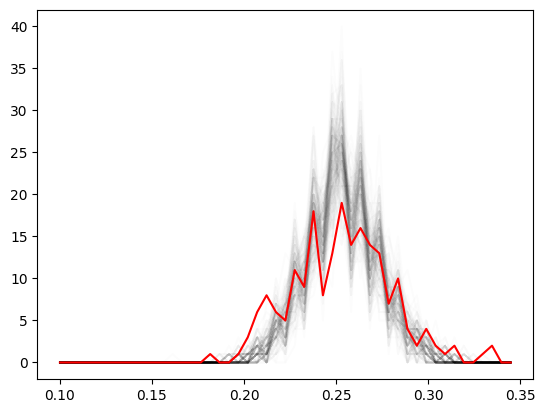

In [ ]:
import matplotlib.pyplot as plt

for mm in matrix_probabilities:
  aaa,bbb = np.histogram(mm,bins=np.linspace(0.10,0.35,50))
  plt.plot(bbb[:-1],aaa,'k',alpha=0.01)

aaa,bbb = np.histogram(m_p_fixed,bins=np.linspace(0.10,0.35,50))
plt.plot(bbb[:-1],aaa,'r')

#plt.hist(matrix_probabilities)

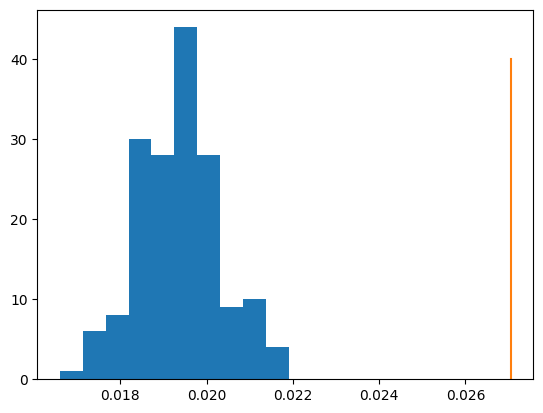

In [ ]:
#from numpy import std
import numpy as np


list_std = []

for gaussian_dist in matrix_probabilities:
  #print(np.std(gaussian_dist))
  list_std.append(np.std(gaussian_dist))

plt.hist(list_std)
plt.plot([np.std(m_p_fixed), np.std(m_p_fixed)],[0, 40])



In [ ]:
with open('saidamatrix_probabilities.txt','w') as f:
  for line in matrix_probabilities:
    f.write('{}\n'.format(line))

In [ ]:
plt.hist(std(m_p_fixed),color='pink')
plt.hist(list_std)